In [1]:
from pga import retrieve_leaderboard, retrieve_schedule, by_rank, by_relative_scores, player_name
import numpy as np
import pandas as pd
from json import JSONDecodeError
import requests

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we'll have a look at some simplistic metrics for performance on the PGA Tour this season, and use these to see which guys are in with a shot as one of Jim Furyk's 4 prospective picks (from a data perspective, at least) ahead of the Ryder Cup in France this September. 

There's been a lot of speculation about who should be included (based on recent regular season and long-term RC performance): with the likes of Finau & DeChambeau making strong cases alongside on-form US team veterans like Woods & Mickelson who only just missed out on points. But if Furyk was taking a purely data-driven approach to selecting guys for his wildcards, who might he be having a look at?

### Grab PGA Tour results (thru Northern Trust)

In [2]:
schedule = retrieve_schedule()
#All 2017/18 events thru Northern Trust
tids = [(tournament['permNum'], tournament['date']['start']) 
        for tournament in schedule['years'][0]['tours'][0]['trns'][:-4]]

#Grab results for US players
results_by_rank = []
results_by_relative_score = []

for (tid, start_date) in tids:
    try:
        leaderboard = retrieve_leaderboard(tid)
        print("{0} {1}".format(leaderboard['tournament_name'], start_date))

        results_by_rank.append(by_rank(leaderboard, nationality='USA'))
        results_by_relative_score.append(by_relative_scores(leaderboard, nationality='USA'))
        
    except JSONDecodeError:
        pass

Safeway Open 2017-10-05
CIMB Classic 2017-10-12
The CJ CUP 2017-10-19
Sanderson Farms Championship 2017-10-26
World Golf Championships-HSBC Champions 2017-10-26
Shriners Hospitals for Children Open 2017-11-02
OHL Classic at Mayakoba 2017-11-09
The RSM Classic 2017-11-16
Hero World Challenge 2017-11-30
QBE Shootout 2017-12-08
Sentry Tournament of Champions 2018-01-04
Sony Open in Hawaii 2018-01-11
CareerBuilder Challenge 2018-01-18
Farmers Insurance Open 2018-01-25
Waste Management Phoenix Open 2018-02-01
AT&T Pebble Beach Pro-Am 2018-02-08
Genesis Open 2018-02-15
The Honda Classic 2018-02-22
World Golf Championships-Mexico Championship 2018-03-01
Valspar Championship 2018-03-08
Arnold Palmer Invitational presented by Mastercard 2018-03-15
Corales Puntacana Resort & Club Championship 2018-03-22
Houston Open 2018-03-29
The Masters 2018-04-05
RBC Heritage 2018-04-12
Valero Texas Open 2018-04-19
Zurich Classic of New Orleans 2018-04-26
Wells Fargo Championship 2018-05-03
THE PLAYERS Champi

### Week-on-week event rank

In [3]:
#Rank values for each week
leaderboard_ts = pd.concat(results_by_rank, axis=1)
leaderboard_ts.columns = [str(_) for _ in np.arange(1, len(leaderboard_ts.columns) + 1)]

#Calculate mean rank, only consider players with at least 10 cuts made this season
leaderboard_ts['mean_rank'] = leaderboard_ts.mean(axis=1)
leaderboard_ts['cuts'] = [len(pd.Series(row).dropna()) for row in leaderboard_ts.values]
leaderboard_ts = leaderboard_ts[leaderboard_ts['cuts'] >= 10]

The rank data for each week is the final position (post-cut) compared to the field at the conclusion of the event (note that this doesn't consider tied examples). This gives a crude idea of finishing performance throughout the regular season so far without consideration of score.

In [4]:
leaderboard_ts.sort_values('cuts', ascending=False).iloc[:5]

,1,2,3,4,5,6,7,8,9,10,...,38,39,40,41,42,43,44,45,mean_rank,cuts
kevin tway,40.0,24.0,16.0,NaN,NaN,31.0,NaN,NaN,NaN,NaN,...,NaN,NaN,11.0,18.0,NaN,NaN,9.0,42.0,29.347826,24
chris kirk,27.0,NaN,31.0,36.0,NaN,NaN,NaN,7.0,NaN,NaN,...,29.0,NaN,52.0,NaN,NaN,18.0,8.0,54.0,23.772727,23
austin cook,NaN,NaN,NaN,26.0,NaN,20.0,34.0,1.0,NaN,17.0,...,NaN,19.0,NaN,NaN,25.0,29.0,NaN,48.0,23.772727,23
beau hossler,56.0,NaN,NaN,15.0,NaN,7.0,26.0,53.0,NaN,NaN,...,NaN,30.0,NaN,NaN,NaN,NaN,NaN,49.0,27.000000,23
charles howell iii,NaN,31.0,10.0,NaN,9.0,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,38.0,NaN,NaN,20.047619,22


As can be seen above, there's a few guys who have ~23 cuts made this year. But how about actual performance? We can have a look at the mean final rank per week for those players that have competed enough this year (assuming 10 or more cuts made). Let's highlight the already-qualified US players to see how they're doing in this view.

In [5]:
us_team = ['dustin johnson', 
           'brooks koepka', 
           'justin thomas', 
           'patrick reed', 
           'bubba watson', 
           'jordan spieth', 
           'rickie fowler', 
           'webb simpson']

(
    leaderboard_ts.sort_values('mean_rank').iloc[:12][['mean_rank', 'cuts']]
    .style.apply(lambda x: ['background: lightblue' if i in us_team
                              else '' for i in x.index])
)

,mean_rank,cuts
dustin johnson,6.5,17
justin thomas,10.5,19
brooks koepka,11.6154,14
rickie fowler,11.75,17
patrick reed,11.9412,18
tiger woods,12.0714,15
patrick cantlay,12.8824,18
tony finau,12.9048,22
webb simpson,13.1111,19
jordan spieth,13.8125,17


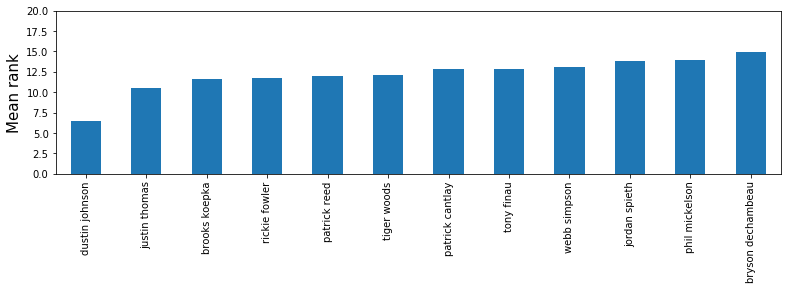

In [6]:
leaderboard_ts.sort_values('mean_rank').iloc[:12]['mean_rank'].plot(ylim=(0, 20), figsize=(13, 3), kind='bar')
plt.ylabel("Mean rank", size=15)

No huge surprises with the best-in-class: world no.1 Dustin Johnson comes out ahead of the pack with a pretty exceptional mean rank of ~6th. He's the only player who has an average rank within the top 10 for this season.

Most of the other auto-qualifiers for the US team are near the top of this metric too: Thomas, Reed, Koepka, Spieth & Fowler are all in the top 10, Simpson & Reed come in at 11th and 12th respectively. The only exception for the existing team is Bubba Watson with a mean rank of 36.06 with 21 events. This is probably down to Bubba's great win at the Dell Technologies Matchplay not being counted as only strokeplay events are used here.

What about the players who haven't qualified automatically?

In [7]:
remaining = set(leaderboard_ts.index) - set(us_team)

potential_picks = (
    leaderboard_ts[leaderboard_ts.index
        .isin(remaining)].sort_values('mean_rank')
    .iloc[:15]
)

potential_picks[['mean_rank', 'cuts']]

,mean_rank,cuts
tiger woods,12.071429,15
patrick cantlay,12.882353,18
tony finau,12.904762,22
phil mickelson,13.941176,18
bryson dechambeau,14.947368,20
kyle stanley,15.062500,17
russell henley,16.642857,15
chez reavie,16.882353,18
zach johnson,17.600000,21
billy horschel,17.666667,16


Tiger Woods' return is made all the more impressive given he's averaging a top 15 finish thru 15 cuts made. Along with Mickelson, you have to expect that both these guys will be the first 2 wildcard picks for Furyk: their combination of Ryder Cup experience and a good 2018 will be invaluable.

Finau and DeChambeau perform well using these metrics, as is to be expected with both being in-form and Bryson picking up the win at last week's Northern Trust. Interestingly, Patrick Cantlay comes out really favourbly here too despite being less associated with the wildcard spots by many.

### Relative strokes to winner

Since the mean week-on-week rank doesn't consider ties or the relative gap between final positions, let's look at a different metric in this context to find out more: _relative score to the eventual winner_. This is calculated by taking the difference of a player's 4 round total from the eventual winner of that event: note that winning an event results in a relative score of 0, the ideal value.

In [8]:
relative_strokes_df = (
    pd.concat([leaderboard['relative_strokes'] for leaderboard 
     in results_by_relative_score if leaderboard is not None], axis=1)
)

leaderboard_ts['mean_relative_strokes'] = relative_strokes_df.mean(axis=1)

(
    leaderboard_ts[['mean_rank', 'cuts', 'mean_relative_strokes']]
    .sort_values('mean_relative_strokes')
    .iloc[:12]
    .style.apply(lambda x: ['background: lightblue' if i in us_team
                              else '' for i in x.index])
)

,mean_rank,cuts,mean_relative_strokes
dustin johnson,6.5,17,5.125
rickie fowler,11.75,17,7.125
tony finau,12.9048,22,7.19048
justin thomas,10.5,19,7.22222
webb simpson,13.1111,19,7.27778
patrick reed,11.9412,18,7.35294
patrick cantlay,12.8824,18,7.47059
tiger woods,12.0714,15,7.5
bryson dechambeau,14.9474,20,8.10526
phil mickelson,13.9412,18,8.11765


DJ still comes out way ahead of his US counterparts, with an average of just over 5 strokes difference from each event winner.

Tiger and Phil are both here again: I think we can safely assume these guys are locks at this stage. Finau, DeChambeau and Cantlay are all still here too.

### Player similarity, and the 'typical' 2018 Ryder Cup player

There's an enormous volume of statistics and metrics available from the PGA about each player's season so far: from scoring averages, to strokes gained on approach, to driving distances, to bouncebackability. In many ways, the sheer number of ways it is possible to dissect the game of touring professionals can make it difficult to identify the most important characteristics. How can we use as expressive a combination of these stats to identify which players are in the upper echelons of performance, and potentially worthy of a place on the team?

Here we construct something known as a _feature vector_ for each player active in 2018 to attempt this. This acts as a performance signature across multiple dimensions of the available data at strokeplay events, ideally covering as many of the pillars of 'good play' as we can. The 13 features selected are:

* Strokes gained: Off the tee
* Strokes gained: Approach
* Strokes gained: Around the green
* Strokes gained: Putting
* Strokes gained: Tee-to-green
* Strokes gained: Total
* Driving distance
* Driving accuracy
* Greens in regulation
* Eagles (holes per)
* Birdie average
* Scoring average
* Sand save percentage

Generating a feature vector for every player in 2018, we can begin to directly measure similarities between each of these and cluster similar players together.

In [9]:
from pga import player_profile, feature_vector, retrieve_all_pids
import pickle

features_dict = {}
for pid in retrieve_all_pids():
    try:
        fv = feature_vector(player_profile(pid))
        
        if len(fv) != 13:
            continue
        
        features_dict[pid] = fv
        
    except (ValueError, JSONDecodeError):
        pass

features_df = pd.DataFrame(features_dict).T

#Normalise the feature vectors
normed_features_df = (features_df - features_df.mean())/features_df.std()

If we assume the guys who have auto-qualified for the US team represent the qualities of good Ryder Cup players, we can build a combination of them by taking their average feature vector. This centre of gravity feature vector represents an anchor point around which Ryder Cup-level performance circulates.

In [10]:
#IDs for the US team as it stands
team_player_ids = ['30925', '32102', '34046', '36689', '33448', '34360', '29221', '25804']

average_rc_player = normed_features_df.loc[[str(pid) for pid in team_player_ids]].mean()
average_rc_player.values #don't worry, these are post-normalised values so won't have much readability

array([ 0.91607331,  0.90605435,  0.9311356 ,  0.483642  ,  1.3756447 ,
        1.60122744,  0.87506994, -0.53504216,  0.60110747, -0.64467215,
        1.32453198, -1.87348021,  0.83992691])

Which prospective US player is most similar to this 'ideal' team member?

In [11]:
from scipy.spatial.distance import cosine
non_team_pids = list(set(normed_features_df.index) - set(team_player_ids))

similarity_results = []
for pid in non_team_pids:
    name = player_name(pid)
    cosine_sim = 1 - cosine(normed_features_df.loc[str(pid)], average_rc_player)
    similarity_results.append((name, cosine_sim))

In [12]:
similarity_df = pd.DataFrame(similarity_results)
similarity_df.columns = ['name', 'similarity']
similarity_df.set_index('name', inplace=True)
similarity_df.sort_values('similarity', ascending=False).iloc[:15]

,similarity
name,
Bryson DeChambeau,0.931240
Patrick Cantlay,0.912422
Tony Finau,0.875127
Tiger Woods,0.807210
Luke List,0.725930
Chesson Hadley,0.706335
Phil Mickelson,0.677740
Zach Johnson,0.674785
Aaron Wise,0.632673


Bryson jumps ahead of both Cantlay and Finau in this view, but the margins are still really tight. I think these metrics show the gap between Cantlay and the two more high-profile prospectives of DeChambeau and Finau is really a lot smaller than it might first appear according to the golf media.

All I can say is: best of luck to Jim Furyk in his selections, and let's go Europe!

### Acknowledgements

* Inspired by `golf.jacodoplessis.co.za`'s Go approach to grabbing PGA Tour API data (located at https://github.com/jacoduplessis/golf)